In [2]:
import exercise2_config as config
import pandas as pd
import numpy as np


train_images = pd.read_csv(config.TRAIN_DATA_FILE, header=None)
test_images = pd.read_csv(config.TEST_DATA_FILE, header=None)

train_data = np.array(train_images.iloc[:,1:])
train_labels = np.array(train_images.iloc[:,0])
test_data = np.array(test_images.iloc[:,1:])
test_labels = np.array(test_images.iloc[:,0])


# REMOVE THIS
#train_data = train_data[:100]
#train_labels = train_labels[:100]
#test_data = test_data[:100]
#test_labels = test_labels[:100] 

In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
from datetime import datetime
ConvergenceWarning('ignore')


def algorithm_pipeline(X_train_data, y_train_data, 
                       model, param_grid, cv=5, scoring_fit='accuracy'):
    # What value should we use for scoring_fit, cv and activation?
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2,
        return_train_score=True # set this for train score
    )
    return gs.fit(X_train_data, y_train_data)


random_state = round(datetime.timestamp(datetime.now()))
print(f'random_state = {random_state}')
mlp = MLPClassifier(random_state=random_state, verbose=2)
parameter_space = {
    # 'hidden_layer_sizes' : np.linspace(10, 100, 5, dtype=int),
    'hidden_layer_sizes' : np.linspace(50, 100, 5, dtype=int),
    # 'hidden_layer_sizes' : [77],
    'activation' : ['logistic'],
    'solver' : ['sgd'],
    'learning_rate_init' : np.linspace(0.001, 0.1, 9), #  Only used when solver=’sgd’ or ‘adam’.
    'learning_rate' : ['constant'] # Only used when solver='sgd'
}
clf = algorithm_pipeline(train_data, train_labels, mlp, parameter_space, 5)

random_state = 1648668123
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Iteration 1, loss = 1.45535309
Iteration 1, loss = 0.76012736
Iteration 1, loss = 1.45854324
Iteration 1, loss = 1.44564497
Iteration 1, loss = 1.45110309
Iteration 1, loss = 1.45210696
Iteration 1, loss = 0.72583594
Iteration 1, loss = 0.70579328
Iteration 2, loss = 0.81112664
Iteration 2, loss = 0.82422204
Iteration 2, loss = 0.53430604
Iteration 2, loss = 0.81300388
Iteration 2, loss = 0.49306965
Iteration 2, loss = 0.81517909
Iteration 2, loss = 0.49958531
Iteration 3, loss = 0.59876658
Iteration 2, loss = 0.81276217
Iteration 3, loss = 0.49164780
Iteration 3, loss = 0.59964268
Iteration 3, loss = 0.50235302
Iteration 3, loss = 0.61037358
Iteration 4, loss = 0.49446797
Iteration 3, loss = 0.59739545
Iteration 3, loss = 0.60181025
Iteration 3, loss = 0.48359069
Iteration 4, loss = 0.46798402
Iteration 4, loss = 0.49670857
Iteration 4, loss = 0.49588940
Iteration 4, loss = 0.50479168
Iteration 5, lo

/home/adriana/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 32, loss = 0.53143261
Iteration 200, loss = 0.04824773
Iteration 193, loss = 0.04936107


/home/adriana/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 21, loss = 0.71229534
[CV] END activation=logistic, hidden_layer_sizes=77, learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time= 8.6min
Iteration 195, loss = 0.04901438
Iteration 195, loss = 0.04905724
[CV] END activation=logistic, hidden_layer_sizes=77, learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time= 8.6min
Iteration 12, loss = 0.75583028
Iteration 33, loss = 0.52991554
Iteration 194, loss = 0.04924889
Iteration 22, loss = 0.75292041
Iteration 196, loss = 0.04890079
Iteration 196, loss = 0.04892698
Iteration 13, loss = 0.73131556
Iteration 1, loss = 0.87691847
Iteration 195, loss = 0.04907046
Iteration 34, loss = 0.52930328
Iteration 197, loss = 0.04879048
Iteration 23, loss = 0.81194860
Iteration 14, loss = 0.75991274
Iteration 197, loss = 0.04893654
Iteration 2, loss = 0.79237367
Iteration 1, loss = 0.92631340
Iteration 35, loss = 0.51749618
Iteration 196, loss = 0.04891444
Iteration 198, loss = 0.04866774
Iteration 15, loss = 

/home/adriana/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 199, loss = 0.04867566
Iteration 3, loss = 0.80746471
Iteration 4, loss = 0.80366698
Iteration 37, loss = 0.54006876
Iteration 17, loss = 0.75089614
Iteration 198, loss = 0.04900086
[CV] END activation=logistic, hidden_layer_sizes=77, learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time= 8.8min
Iteration 26, loss = 0.79109228
Iteration 200, loss = 0.04859314


/home/adriana/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 18, loss = 0.74080643
Iteration 4, loss = 0.80444512
Iteration 38, loss = 0.60303208
Iteration 199, loss = 0.04891479
Iteration 5, loss = 0.75149628
Iteration 27, loss = 0.75525453
Iteration 19, loss = 0.70374874
[CV] END activation=logistic, hidden_layer_sizes=77, learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time= 8.9min
Iteration 200, loss = 0.04880343
Iteration 5, loss = 0.82594123


/home/adriana/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.97713278
Iteration 39, loss = 0.56764868Iteration 6, loss = 0.82226951

Iteration 28, loss = 0.81646602
Iteration 20, loss = 0.65997820
[CV] END activation=logistic, hidden_layer_sizes=77, learning_rate=constant, learning_rate_init=0.001, solver=sgd; total time= 8.9min
Iteration 6, loss = 0.76388738
Iteration 2, loss = 0.92887886
Iteration 7, loss = 0.70803460
Iteration 40, loss = 0.56119816
Iteration 29, loss = 0.75386623
Iteration 21, loss = 0.64028858
Iteration 1, loss = 1.03598608
Iteration 8, loss = 0.81058356
Iteration 7, loss = 0.86176551
Iteration 3, loss = 0.81662835
Iteration 30, loss = 0.79542359
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 41, loss = 0.52243337
Iteration 22, loss = 0.65287424
Iteration 1, loss = 0.95315669
[CV] END activation=logistic, hidden_layer_sizes=77, learning_rate=constant, learning_rate_init=0.07525000000000001, solver=sgd; total time= 1.5min
Iteration 9, loss = 0.75683353

/home/adriana/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [18]:
print(f'random_state = {random_state}')
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)
print(clf.score(test_data, test_labels))

random_state = 1648668123
MLPClassifier(activation='logistic', hidden_layer_sizes=77,
              random_state=1648668123, solver='sgd', verbose=2)
{'activation': 'logistic', 'hidden_layer_sizes': 77, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'solver': 'sgd'}
0.9492666666666667
0.958


In [13]:
class Result:
  def __init__(self, hidden_layer_size, learning_rate, max_iter, accuracy):
    self.hidden_layer_size = hidden_layer_size
    self.learning_rate = learning_rate
    self.max_iter = max_iter
    self.accuracy = accuracy

results = []
for index in range(len(clf.cv_results_['param_hidden_layer_sizes'])):
  result = Result(clf.cv_results_['param_hidden_layer_sizes'][index],
                  clf.cv_results_['param_learning_rate_init'][index],
                  # clf.cv_results_['param_max_iter'][index],
                  0,
                  clf.cv_results_['mean_test_score'][index])
  results.append(result)


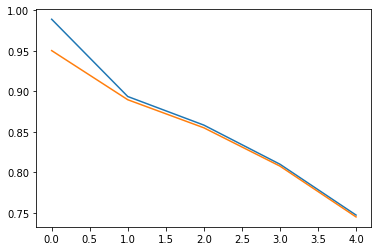

/home/adriana/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


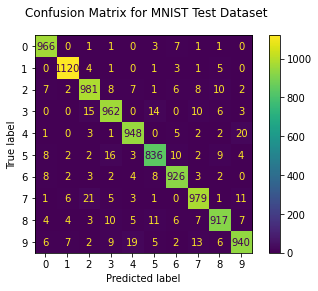

In [14]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plt.plot(clf.cv_results_['mean_train_score'], label='Train')
plt.plot(clf.cv_results_['mean_test_score'], label='Test')
plt.show()

fig=plot_confusion_matrix(clf, test_data, test_labels, display_labels=["0","1","2","3","4","5","6","7","8","9"])
fig.figure_.suptitle("Confusion Matrix for MNIST Test Dataset")
plt.show()

# Report

In [15]:
from pylatex import Document, Command, LongTable
from pylatex.utils import NoEscape

doc = Document(page_numbers=False)

# Add title
doc.preamble.append(Command('title', 'Exercise 2b - MLP'))
doc.preamble.append(Command('date', ''))
doc.append(NoEscape(r'\maketitle'))


# Add table with results
with doc.create(LongTable('l l l l l')) as data_table:
  data_table.add_hline()
  data_table.add_row(['Hidden Layer Size', 'Learning Rate', 'Max Iterations', 'Accuracy', 'Best?'])
  data_table.add_hline()
  data_table.end_table_header()
  data_table.add_hline()

  for result in results:
    row = [result.hidden_layer_size,
           round(result.learning_rate, 5),
           result.max_iter,
           round(result.accuracy, 5), 
           'YES' if round(clf.best_score_, 5) == round(result.accuracy, 5) else ''] 

    data_table.add_row(row)
    data_table.add_hline()

  data_table.end_table_last_footer()
  

try:
  doc.generate_pdf('E2b')
  doc.generate_tex('E2b')
except:
  # The generate_pdf sometimes fails and prints some message, but the pdf is actually generated. 
  # Not worth debugging :)
  pass
